In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.patches as mpatches

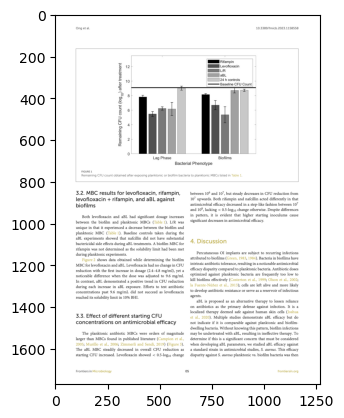

In [2]:
img_full = cv2.imread('./../../samples/imgPDF.png')
plt.imshow(img_full)

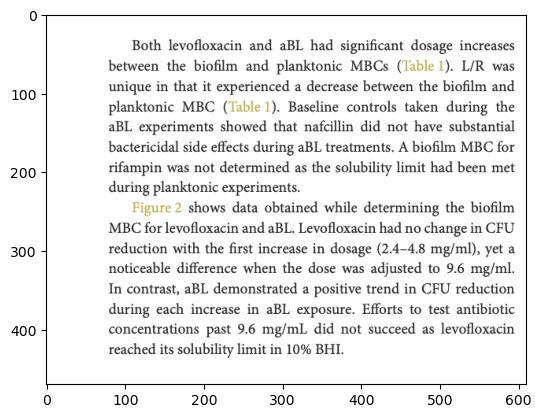

In [3]:
img = img_full[930:1400, 20:630]
plt.imshow(img)

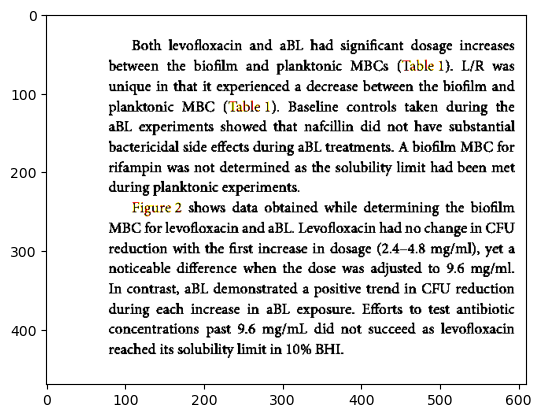

In [4]:
_,imgThresh1 = cv2.threshold(img,200,255,cv2.THRESH_BINARY)
plt.imshow(imgThresh1,cmap='gray')

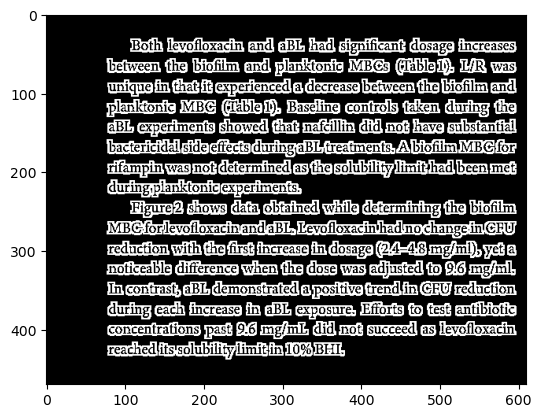

In [5]:
bs = 5
k = -0.2
maxval = 255
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgThresh2 = cv2.ximgproc.niBlackThreshold(img1,maxValue=maxval,
                                           type=cv2.THRESH_BINARY,blockSize=bs,k=k)
plt.imshow(imgThresh2,cmap='gray')

In [6]:
def preprocess(totalLabels,stats, centroids):
    columns = ['label_id', 'left','top','width','height','area','centroid_x','centroid_y']
    df = pd.DataFrame(columns=columns)
    df['label_id'] = [i for i in range(1,totalLabels+1)]
    df['left'] = stats[:,0]
    df['top'] = stats[:,1]
    df['width'] = stats[:,2]
    df['height'] = stats[:,3]
    df['area'] = stats[:,4]
    df['centroid_x'] = centroids[:,0]
    df['centroid_y'] = centroids[:,1]
    return df

In [7]:
def preprocess_helper(df):
    df['aspect_ratio'] = np.round(df['width']/df['height'],2)
    
    df = df[(df['area'] > 50) & (df['aspect_ratio'] > 1.9) & (df['area'] < 3000)]
    df = df.sort_values(by=['top', 'left']).reset_index(drop=True)
    
    df['rowID'] = 1
    row_id = 1
    prev_val = df.loc[0, 'top']
    thresh = 10

    for idx in range(1, df.shape[0]):
        curr_val = df.loc[idx, 'top']
        if curr_val - prev_val > thresh:
            row_id += 1
        prev_val = curr_val
        df.at[idx, 'rowID'] = int(row_id)

    df['columnID'] = df.groupby('rowID')['left'].rank().astype(int)
    return df

In [8]:
totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(imgThresh2,4,cv2.CV_32S)
comp_df = preprocess(totalLabels,stats, centroid)
comp_df.shape

(373, 8)

In [9]:
comp_df = preprocess_helper(comp_df)
comp_df.shape

(85, 11)

In [10]:
comp_df

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,rowID,columnID
0,2,107,30,42,19,388,128.515464,39.796392,2.21,1,1
1,3,154,30,98,19,937,201.500534,40.469584,5.16,1,2
2,7,372,30,85,23,892,413.839686,40.659193,3.70,1,3
3,8,462,30,57,23,538,490.334572,41.392193,2.48,1,4
4,9,524,31,74,18,712,559.702247,41.122191,4.11,1,5
...,...,...,...,...,...,...,...,...,...,...,...
80,335,78,391,119,18,1103,137.480508,401.002720,6.61,15,1
81,360,78,416,64,19,646,110.178019,426.411765,3.37,16,1
82,361,143,416,139,23,1527,212.889980,425.972495,6.04,16,2
83,363,304,417,35,18,377,320.816976,425.424403,1.94,16,3


In [11]:
def plot_components(df,comps=[]):
    output = img.copy() 
    for comp in comps:
        x, y, w, h, area = df[df['label_id'] == comp][['left','top','width','height','area']].values[0]
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(output)

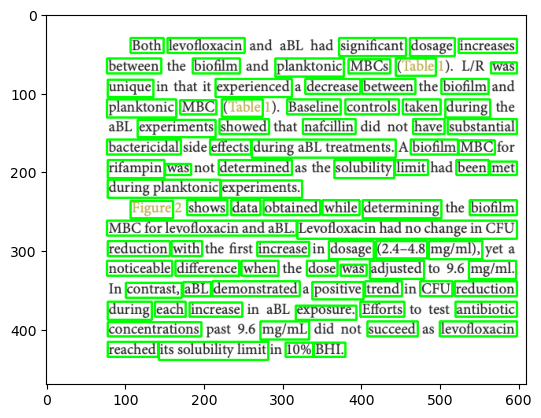

In [12]:
plot_components(comp_df,comps=comp_df.label_id.unique())

In [13]:
comp_df

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,rowID,columnID
0,2,107,30,42,19,388,128.515464,39.796392,2.21,1,1
1,3,154,30,98,19,937,201.500534,40.469584,5.16,1,2
2,7,372,30,85,23,892,413.839686,40.659193,3.70,1,3
3,8,462,30,57,23,538,490.334572,41.392193,2.48,1,4
4,9,524,31,74,18,712,559.702247,41.122191,4.11,1,5
...,...,...,...,...,...,...,...,...,...,...,...
80,335,78,391,119,18,1103,137.480508,401.002720,6.61,15,1
81,360,78,416,64,19,646,110.178019,426.411765,3.37,16,1
82,361,143,416,139,23,1527,212.889980,425.972495,6.04,16,2
83,363,304,417,35,18,377,320.816976,425.424403,1.94,16,3


In [14]:
def plot_nn_patch(df,img,root_label, neighbor_labels):          
    output = img.copy()
    count = 0
    x,y,w,h = df[df['label_id'] == root_label][['left','top','width','height']].values[0]  
    print(df[df['label_id'] == root_label])
    cv2.rectangle(output, (x, y), (x + w, y + h),(255,0,0) , 2)
    for neighbor in neighbor_labels:
        count += 1
        x1,y1,w1,h1 = df[df['label_id'] == neighbor][['left','top','width','height']].values[0]
        cv2.rectangle(output, (x1, y1), (x1 + w1, y1 + h1),(0, 255,0) , 2)
        cv2.putText(output, str(count), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        #cv2.circle(output, (100, 100), 5, (255, 255, 255), -1)
    plt.imshow(output)

In [15]:
def build_single_lexicon(label_id, df, k=5):
    if label_id not in df['label_id'].values:
        print("unknown component")
        return
    x,y,w,h,r,c = df[df['label_id'] == label_id][['left','top','width','height','rowID','columnID']].values[0]
    r1 = (df['rowID'] >= r-1)
    r2 = (df['rowID'] <= r+1)    
    

    temp_df = df[r1 & r2]
    temp_df = temp_df[temp_df['label_id'] != label_id]

    
    temp_df['new_centroid_x'] = (temp_df['centroid_x']-x)
    temp_df['new_centroid_y'] = (y-temp_df['centroid_y'])
    temp_df['new_left'] = (temp_df['left']-x)/w
    temp_df['new_top'] = (y-temp_df['top'])/w
    temp_df['new_width'] = temp_df['width']/w
    temp_df['new_height'] = temp_df['height']/w
    
    #rotation-invariance
    
    #scale-invariance
    temp_df['new_centroid_x'] = temp_df['new_centroid_x']/w
    temp_df['new_centroid_y'] = temp_df['new_centroid_y']/w
    
    #calculate distance & angle
    temp_df['Euclidean'] = np.sqrt(temp_df['new_centroid_y']**2 + temp_df['new_centroid_x']**2)
    temp_df['theta'] = np.degrees(np.arctan2(temp_df['new_centroid_y'], temp_df['new_centroid_x']))
    temp_df['theta'] = (temp_df['theta'] + 360) % 360 
    temp_df.loc[temp_df['theta'] > 350, 'theta'] = 0
    temp_df.loc[temp_df['theta'] < 2, 'theta'] = 0
    temp_df['quadrant'] = pd.cut(temp_df['theta'], 8, labels=range(1,9))
     
    
    res_df = temp_df.sort_values(by=['Euclidean','theta'])[:k]
    res_df = res_df.sort_values(by=['theta'])
    
    res_df['tl_corner'] = res_df.apply(lambda row: (row['new_left'], row['new_top']), axis=1)
    res_df['br_corner'] = res_df.apply(lambda row: (row['new_left']+row['new_width'], row['new_top']+row['new_height']), axis=1)
                
    return res_df

In [16]:
word = 85
res = build_single_lexicon(word, comp_df,k=5)
res

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,rowID,...,new_centroid_y,new_left,new_top,new_width,new_height,Euclidean,theta,quadrant,tl_corner,br_corner
20,86,453,108,48,19,479,475.087683,118.440501,2.53,4,...,-0.153537,1.073529,0.000000,0.705882,0.279412,1.406752,0.000000,1,"(1.0735294117647058, 0.0)","(1.7794117647058822, 0.27941176470588236)"
13,58,401,82,68,19,674,432.735905,92.893175,3.58,3,...,0.222159,0.308824,0.382353,1.000000,0.279412,0.806721,15.984988,1,"(0.3088235294117647, 0.38235294117647056)","(1.3088235294117647, 0.6617647058823529)"
12,57,329,82,70,19,664,363.685241,93.126506,3.68,3,...,0.218728,-0.750000,0.382353,1.029412,0.279412,0.324661,137.645858,4,"(-0.75, 0.38235294117647056)","(0.27941176470588225, 0.6617647058823529)"
18,84,306,108,68,19,675,339.696296,118.254815,3.58,4,...,-0.150806,-1.088235,0.000000,1.000000,0.279412,0.611586,194.275342,5,"(-1.088235294117647, 0.0)","(-0.08823529411764697, 0.27941176470588236)"
24,105,326,133,67,19,717,359.238494,142.748954,3.53,5,...,-0.511014,-0.794118,-0.367647,0.985294,0.279412,0.595276,239.142890,6,"(-0.7941176470588235, -0.36764705882352944)","(0.1911764705882354, -0.08823529411764708)"


    label_id  left  top  width  height  area  centroid_x  centroid_y  \
19        85   380  108     68      19   628  414.617834  118.727707   

    aspect_ratio  rowID  columnID  
19          3.58      4         5  


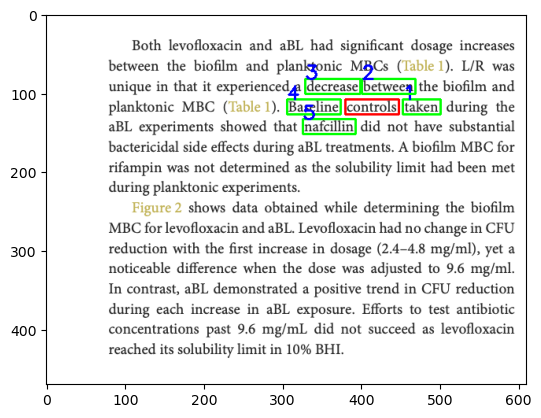

In [17]:
plot_nn_patch(comp_df,img,word,res.label_id.unique())

In [18]:
word = 364
res = build_single_lexicon(word, comp_df,k=5)
res

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,rowID,...,new_centroid_y,new_left,new_top,new_width,new_height,Euclidean,theta,quadrant,tl_corner,br_corner
78,339,408,390,64,19,625,439.587200,400.977600,3.37,15,...,0.400560,1.700,0.675,1.600,0.475,2.521697,9.139887,1,"(1.7, 0.675)","(3.3, 1.15)"
77,337,272,390,62,23,614,302.978827,400.863192,2.70,15,...,0.403420,-1.700,0.675,1.550,0.575,1.009630,156.448551,7,"(-1.7, 0.675)","(-0.1499999999999999, 1.25)"
80,335,78,391,119,18,1103,137.480508,401.002720,6.61,15,...,0.399932,-6.550,0.650,2.975,0.450,5.078758,175.483509,7,"(-6.55, 0.65)","(-3.5749999999999997, 1.1)"
82,361,143,416,139,23,1527,212.889980,425.972495,6.04,16,...,-0.224312,-4.925,0.025,3.475,0.575,3.185658,184.037721,8,"(-4.925, 0.025)","(-1.4499999999999997, 0.6)"
83,363,304,417,35,18,377,320.816976,425.424403,1.94,16,...,-0.210610,-0.900,0.000,0.875,0.450,0.523784,203.709126,8,"(-0.9, 0.0)","(-0.025000000000000022, 0.45)"


    label_id  left  top  width  height  area  centroid_x  centroid_y  \
84       364   340  417     40      18   416  360.387019  425.370192   

    aspect_ratio  rowID  columnID  
84          2.22     16         4  


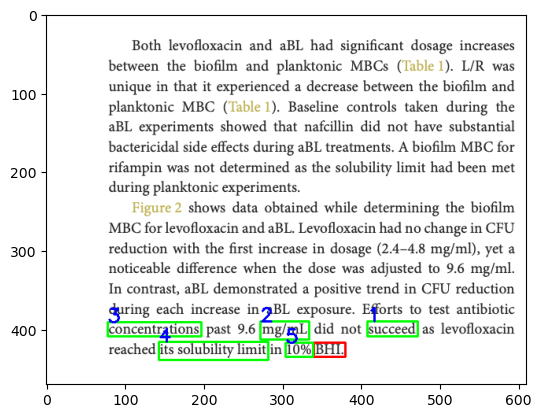

In [19]:
plot_nn_patch(comp_df,img,word,res.label_id.unique())

In [20]:
word = 209
res = build_single_lexicon(word, comp_df,k=5)
res

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,rowID,...,new_centroid_y,new_left,new_top,new_width,new_height,Euclidean,theta,quadrant,tl_corner,br_corner
43,187,235,236,37,19,388,252.824742,246.396907,1.95,9,...,0.064743,0.655602,0.107884,0.153527,0.078838,0.732430,5.071275,1,"(0.6556016597510373, 0.1078838174273859)","(0.8091286307053942, 0.18672199170124482)"
42,186,179,236,51,19,510,203.460784,246.817647,2.68,9,...,0.062997,0.423237,0.107884,0.211618,0.078838,0.528502,6.845926,1,"(0.42323651452282157, 0.1078838174273859)","(0.6348547717842323, 0.18672199170124482)"
48,184,107,237,54,22,557,131.983842,246.964093,2.45,9,...,0.062390,0.124481,0.103734,0.224066,0.091286,0.236525,15.294212,1,"(0.12448132780082988, 0.1037344398340249)","(0.34854771784232363, 0.1950207468879668)"
51,227,78,288,79,19,763,116.117955,298.588467,4.16,11,...,-0.151819,0.004149,-0.107884,0.327801,0.078838,0.222251,316.913644,8,"(0.004149377593360996, -0.1078838174273859)","(0.33195020746887965, -0.02904564315352698)"
52,228,159,288,39,19,414,178.256039,298.038647,2.05,11,...,-0.149538,0.340249,-0.107884,0.161826,0.078838,0.445968,340.408541,8,"(0.34024896265560167, -0.1078838174273859)","(0.5020746887966805, -0.02904564315352698)"


    label_id  left  top  width  height  area  centroid_x  centroid_y  \
49       209    77  262    241      19  2401  193.225739  272.088297   

    aspect_ratio  rowID  columnID  
49         12.68     10         1  


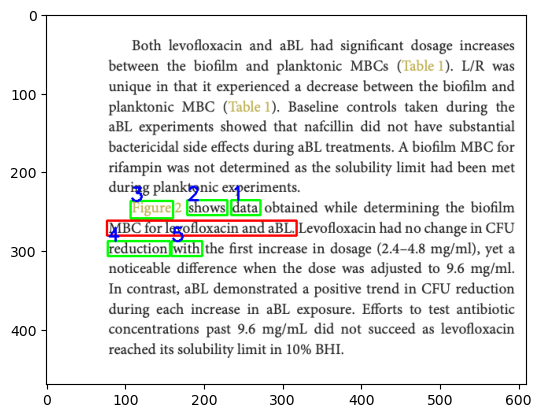

In [21]:
plot_nn_patch(comp_df,img,word,res.label_id.unique())

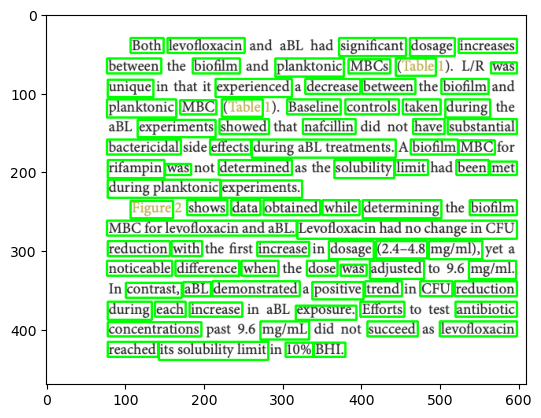

In [22]:
plot_components(comp_df,comps=comp_df.label_id.unique())

In [23]:
word = 129
res = build_single_lexicon(word, comp_df,k=5)
res

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,rowID,...,new_centroid_y,new_left,new_top,new_width,new_height,Euclidean,theta,quadrant,tl_corner,br_corner
32,132,524,160,46,18,512,546.970703,168.228516,2.56,6,...,-0.153809,1.016667,-0.016667,0.766667,0.300000,1.407938,0.000000,1,"(1.0166666666666666, -0.016666666666666666)","(1.7833333333333332, 0.2833333333333333)"
25,107,466,133,40,19,418,484.468900,143.684211,2.11,5,...,0.255263,0.050000,0.433333,0.666667,0.316667,0.439535,35.503842,1,"(0.05, 0.43333333333333335)","(0.7166666666666667, 0.75)"
35,153,366,185,76,23,837,405.071685,195.139785,3.30,7,...,-0.602330,-1.616667,-0.433333,1.266667,0.383333,1.137953,211.958835,5,"(-1.6166666666666667, -0.43333333333333335)","(-0.3500000000000001, -0.04999999999999999)"
36,154,443,185,42,19,455,463.494505,194.593407,2.21,7,...,-0.593223,-0.333333,-0.433333,0.700000,0.316667,0.593281,270.795969,7,"(-0.3333333333333333, -0.43333333333333335)","(0.36666666666666664, -0.1166666666666667)"
37,156,521,185,41,19,392,539.834184,195.676020,2.16,7,...,-0.611267,0.966667,-0.433333,0.683333,0.316667,1.418981,334.482996,8,"(0.9666666666666667, -0.43333333333333335)","(1.65, -0.1166666666666667)"


    label_id  left  top  width  height  area  centroid_x  centroid_y  \
31       129   463  159     60      19   624  491.267628  168.520833   

    aspect_ratio  rowID  columnID  
31          3.16      6         4  


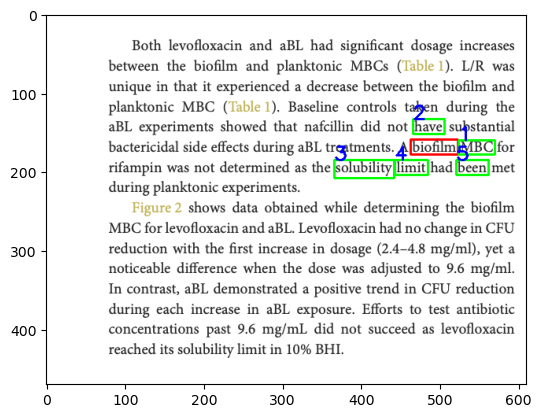

In [24]:
plot_nn_patch(comp_df,img,word,res.label_id.unique())

In [25]:
word = 158
res = build_single_lexicon(word, comp_df,k=5)
res

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,rowID,...,new_centroid_y,new_left,new_top,new_width,new_height,Euclidean,theta,quadrant,tl_corner,br_corner
32,132,524,160,46,18,512,546.970703,168.228516,2.56,6,...,0.552102,-1.176471,0.794118,1.352941,0.529412,0.745439,132.213991,1,"(-1.1764705882352942, 0.7941176470588235)","(0.17647058823529416, 1.3235294117647058)"
31,129,463,159,60,19,624,491.267628,168.520833,3.16,6,...,0.543505,-2.970588,0.823529,1.764706,0.558824,2.207152,165.744452,4,"(-2.9705882352941178, 0.8235294117647058)","(-1.2058823529411766, 1.3823529411764706)"
35,153,366,185,76,23,837,405.071685,195.139785,3.30,7,...,-0.239405,-5.823529,0.058824,2.235294,0.676471,4.680489,182.931939,7,"(-5.823529411764706, 0.058823529411764705)","(-3.5882352941176467, 0.7352941176470589)"
36,154,443,185,42,19,455,463.494505,194.593407,2.21,7,...,-0.223335,-3.558824,0.058824,1.235294,0.558824,2.964469,184.320611,7,"(-3.5588235294117645, 0.058823529411764705)","(-2.3235294117647056, 0.6176470588235294)"
37,156,521,185,41,19,392,539.834184,195.676020,2.16,7,...,-0.255177,-1.264706,0.058824,1.205882,0.558824,0.755178,199.749172,8,"(-1.2647058823529411, 0.058823529411764705)","(-0.05882352941176472, 0.6176470588235294)"


    label_id  left  top  width  height  area  centroid_x  centroid_y  \
38       158   564  187     34      17   337  581.721068  195.893175   

    aspect_ratio  rowID  columnID  
38           2.0      7         7  


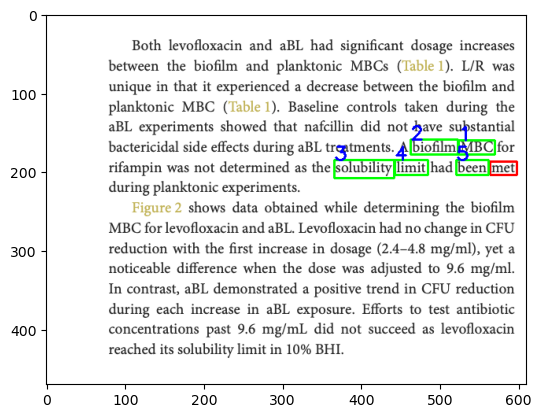

In [26]:
plot_nn_patch(comp_df,img,word,res.label_id.unique())

In [27]:
word = 173
res = build_single_lexicon(word, comp_df,k=5)
res

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,rowID,...,new_centroid_y,new_left,new_top,new_width,new_height,Euclidean,theta,quadrant,tl_corner,br_corner
39,159,151,190,33,14,324,167.570988,196.416667,2.36,7,...,0.094988,0.510490,0.139860,0.230769,0.097902,0.633532,8.623134,1,"(0.5104895104895105, 0.13986013986013987)","(0.7412587412587412, 0.23776223776223776)"
33,150,78,185,72,23,747,112.564926,195.734940,3.13,7,...,0.099756,0.000000,0.174825,0.503497,0.160839,0.261489,22.426103,1,"(0.0, 0.17482517482517482)","(0.5034965034965035, 0.3356643356643356)"
48,184,107,237,54,22,557,131.983842,246.964093,2.45,9,...,-0.258490,0.202797,-0.188811,0.377622,0.153846,0.457527,325.599577,8,"(0.20279720279720279, -0.1888111888111888)","(0.5804195804195804, -0.03496503496503495)"
42,186,179,236,51,19,510,203.460784,246.817647,2.68,9,...,-0.257466,0.706294,-0.181818,0.356643,0.132867,0.914346,343.645178,8,"(0.7062937062937062, -0.18181818181818182)","(1.062937062937063, -0.04895104895104896)"
43,187,235,236,37,19,388,252.824742,246.396907,1.95,9,...,-0.254524,1.097902,-0.181818,0.258741,0.132867,1.248764,348.239537,8,"(1.097902097902098, -0.18181818181818182)","(1.3566433566433567, -0.04895104895104896)"


    label_id  left  top  width  height  area  centroid_x  centroid_y  \
40       173    78  210    143      23  1461  148.927447  220.638604   

    aspect_ratio  rowID  columnID  
40          6.22      8         1  


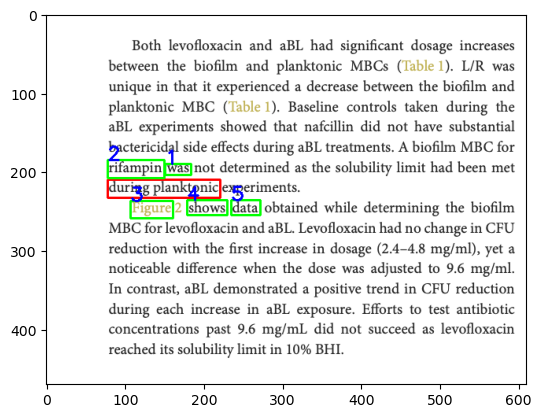

In [28]:
plot_nn_patch(comp_df,img,word,res.label_id.unique())

In [29]:
word = 192
res = build_single_lexicon(word, comp_df,k=5)
res

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,rowID,...,new_centroid_y,new_left,new_top,new_width,new_height,Euclidean,theta,quadrant,tl_corner,br_corner
41,174,222,211,103,22,990,273.487879,221.352525,4.68,8,...,0.244125,-5.266667,0.416667,1.716667,0.366667,4.415289,176.830458,1,"(-5.266666666666667, 0.4166666666666667)","(-3.55, 0.7833333333333333)"
44,188,276,236,72,19,733,311.375171,246.145975,3.79,9,...,-0.169100,-4.366667,0.000000,1.200000,0.316667,3.780864,182.563416,2,"(-4.366666666666666, 0.0)","(-3.166666666666666, 0.31666666666666665)"
45,189,351,236,47,19,505,374.316832,245.891089,2.47,9,...,-0.164851,-3.116667,0.000000,0.783333,0.316667,2.733029,183.458079,2,"(-3.1166666666666667, 0.0)","(-2.3333333333333335, 0.31666666666666665)"
46,190,402,236,100,23,987,451.398176,246.666667,4.35,9,...,-0.177778,-2.266667,0.000000,1.666667,0.383333,1.454271,187.021703,3,"(-2.2666666666666666, 0.0)","(-0.5999999999999999, 0.38333333333333336)"
50,210,319,262,279,23,2784,461.568606,272.424569,12.13,10,...,-0.607076,-3.650000,-0.433333,4.650000,0.383333,1.411117,205.480860,8,"(-3.65, -0.43333333333333335)","(1.0000000000000004, -0.04999999999999999)"


    label_id  left  top  width  height  area  centroid_x  centroid_y  \
47       192   538  236     60      19   615  566.276423  245.473171   

    aspect_ratio  rowID  columnID  
47          3.16      9         7  


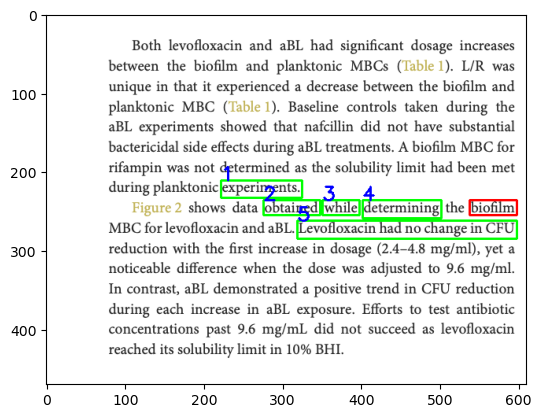

In [30]:
plot_nn_patch(comp_df,img,word,res.label_id.unique())

In [31]:
comp_df['label_id'].values

array([  2,   3,   7,   8,   9,  29,  31,  33,  35,  34,  39,  56,  57,
        58,  60,  52,  80,  82,  84,  85,  86,  87,  81, 103, 105, 107,
       108, 110, 125, 127, 128, 129, 132, 150, 151, 153, 154, 156, 158,
       159, 173, 174, 186, 187, 188, 189, 190, 192, 184, 209, 210, 227,
       228, 233, 234, 235, 231, 253, 254, 255, 257, 258, 259, 263, 283,
       284, 285, 286, 289, 290, 288, 308, 309, 310, 311, 312, 319, 337,
       339, 340, 335, 360, 361, 363, 364])

In [32]:
word = 210
res = build_single_lexicon(word, comp_df,k=5)
res

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,rowID,...,new_centroid_y,new_left,new_top,new_width,new_height,Euclidean,theta,quadrant,tl_corner,br_corner
45,189,351,236,47,19,505,374.316832,245.891089,2.47,9,...,0.057738,0.114695,0.093190,0.168459,0.068100,0.206504,16.236180,1,"(0.11469534050179211, 0.0931899641577061)","(0.2831541218637993, 0.16129032258064518)"
44,188,276,236,72,19,733,311.375171,246.145975,3.79,9,...,0.056824,-0.154122,0.093190,0.258065,0.068100,0.063055,115.684748,3,"(-0.15412186379928317, 0.0931899641577061)","(0.10394265232974909, 0.16129032258064518)"
43,187,235,236,37,19,388,252.824742,246.396907,1.95,9,...,0.055925,-0.301075,0.093190,0.132616,0.068100,0.243691,166.732866,4,"(-0.3010752688172043, 0.0931899641577061)","(-0.16845878136200718, 0.16129032258064518)"
56,231,268,289,66,18,643,299.965785,299.024883,3.67,11,...,-0.132706,-0.182796,-0.096774,0.236559,0.064516,0.149215,242.792644,6,"(-0.1827956989247312, -0.0967741935483871)","(0.05376344086021506, -0.03225806451612903)"
53,233,359,288,57,23,531,387.677966,299.525424,2.48,11,...,-0.134500,0.143369,-0.093190,0.204301,0.082437,0.280506,331.347947,8,"(0.14336917562724014, -0.0931899641577061)","(0.34767025089605735, -0.010752688172043015)"


    label_id  left  top  width  height  area  centroid_x  centroid_y  \
50       210   319  262    279      23  2784  461.568606  272.424569   

    aspect_ratio  rowID  columnID  
50         12.13     10         2  


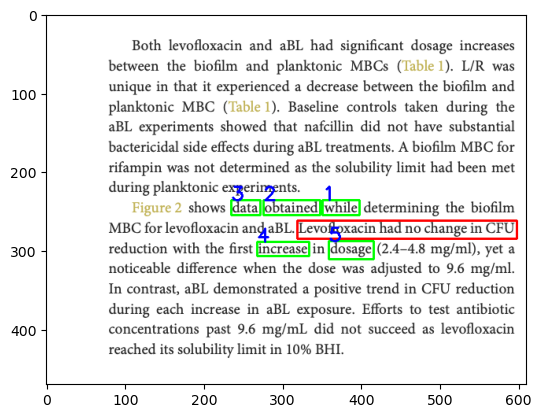

In [33]:
plot_nn_patch(comp_df,img,word,res.label_id.unique())

In [34]:
query_context_vectors = []
for label in comp_df.label_id.values:
    try:
        res = build_single_lexicon(word, comp_df,k=5)
        query_context_vectors.append(res[['tl_corner','br_corner']].values)
    except EXception as e:
        print()

In [35]:
len(query_context_vectors)

85

In [36]:
query_context_vectors[0]

array([[(0.11469534050179211, 0.0931899641577061),
        (0.2831541218637993, 0.16129032258064518)],
       [(-0.15412186379928317, 0.0931899641577061),
        (0.10394265232974909, 0.16129032258064518)],
       [(-0.3010752688172043, 0.0931899641577061),
        (-0.16845878136200718, 0.16129032258064518)],
       [(-0.1827956989247312, -0.0967741935483871),
        (0.05376344086021506, -0.03225806451612903)],
       [(0.14336917562724014, -0.0931899641577061),
        (0.34767025089605735, -0.010752688172043015)]], dtype=object)

In [37]:
def build_context_layout(img):
    _,imgThresh1 = cv2.threshold(img,200,255,cv2.THRESH_BINARY)
    bs = 5
    k = -0.2
    maxval = 255
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgThresh2 = cv2.ximgproc.niBlackThreshold(img1,maxValue=maxval,
                                               type=cv2.THRESH_BINARY,blockSize=bs,k=k)
    
    totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(imgThresh2,4,cv2.CV_32S)
    df = preprocess(totalLabels,stats, centroid)
    df = preprocess_helper(df)
    print("total no of words identified:",df.shape[0])
    
    context_vectors = []
    k_neigh = 5
    for label in df.label_id.values:
        try:
            res = build_single_lexicon(label, df,k=k_neigh)
            if(res.shape[0] >= k_neigh):
                context_vectors.append(res[['tl_corner','br_corner']].values)
        except Exception as e:
            print()
            
    flattened_tuples = [np.array([item for sublist in t for item in sublist]) for t in context_vectors]
    array_of_tuples = np.array(flattened_tuples)
    context_vectors = array_of_tuples.reshape(len(context_vectors), k_neigh, 4)
    print("total no of contexts extracted:",context_vectors.shape[0])
    
    return context_vectors

In [38]:
query_vectors = build_context_layout(img)
len(query_vectors)

total no of words identified: 85
total no of contexts extracted: 85


85

In [39]:
query_vectors.shape

(85, 5, 4)

In [40]:
doc_vectors = build_context_layout(img_full)
len(doc_vectors)

total no of words identified: 289
total no of contexts extracted: 280


280

In [41]:
doc_vectors.shape

(280, 5, 4)

In [42]:
doc_vectors

array([[[ 2.        , -0.30909091,  3.94545455, -0.01818182],
        [ 3.96363636, -0.30909091,  5.78181818,  0.03636364],
        [ 5.8       , -0.30909091,  8.41818182,  0.01818182],
        [ 0.01818182, -0.30909091,  1.36363636,  0.03636364],
        [ 1.38181818, -0.30909091,  1.98181818, -0.01818182]],

       [[ 1.01351351,  0.        ,  1.45945946,  0.21621622],
        [ 1.47297297,  0.        ,  2.91891892,  0.21621622],
        [-0.01351351,  0.22972973,  0.72972973,  0.41891892],
        [ 0.31081081, -1.08108108,  1.10810811, -0.75675676],
        [ 1.16216216, -1.08108108,  2.25675676, -0.75675676]],

       [[ 1.03030303,  0.        ,  4.27272727,  0.48484848],
        [-2.3030303 ,  0.51515152, -0.63636364,  0.93939394],
        [-2.27272727,  0.        , -0.03030303,  0.57575758],
        [-1.57575758, -2.42424242,  0.21212121, -1.6969697 ],
        [ 0.33333333, -2.42424242,  2.78787879, -1.6969697 ]],

       ...,

       [[ 1.03030303,  0.15151515,  2.21212121,  0.

In [45]:
def count_matches(query_vectors,doc_vectors):
    matches = 0
    for v_query in query_vectors:
        for v_doc in doc_vectors:
            if(v_doc.all() == v_query.all()):
                 matches += 1 
                 break
    return matches, 100*matches/len(query_vectors)

In [46]:
count_matches(query_vectors,doc_vectors)

(85, 100.0)

In [44]:
len(num_matches[num_matches == 1]),len(num_matches[num_matches ==0])

(82, 3)

In [80]:
def count2_matches(query_vectors,doc_vectors):
    matches = np.all(query_vectors[:, np.newaxis] == doc_vectors, axis=(2, 3))
    num_matches = np.sum(matches, axis=1)
    num_matches = len(num_matches[num_matches == 1])
    return num_matches, 100*num_matches/len(query_vectors)

In [81]:
count2_matches(query_vectors,doc_vectors)

(82, 96.47058823529412)

In [47]:
img.shape

(470, 610, 3)

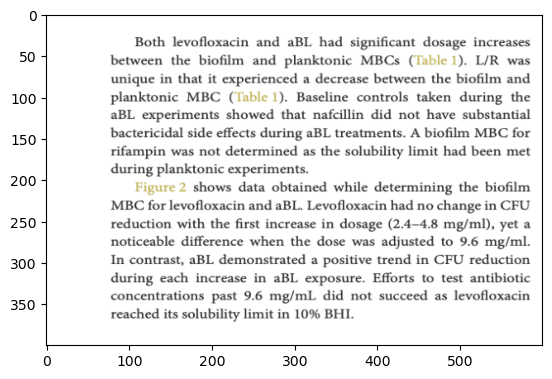

In [48]:
img2 = cv2.resize(img, (600, 400))
plt.imshow(img2)

In [49]:
query2_vectors = build_context_layout(img2)
len(query2_vectors)

total no of words identified: 90
total no of contexts extracted: 90


90

In [50]:
count_matches(query2_vectors,doc_vectors)

(90, 100.0)

In [82]:
count2_matches(query2_vectors,doc_vectors)

(0, 0.0)

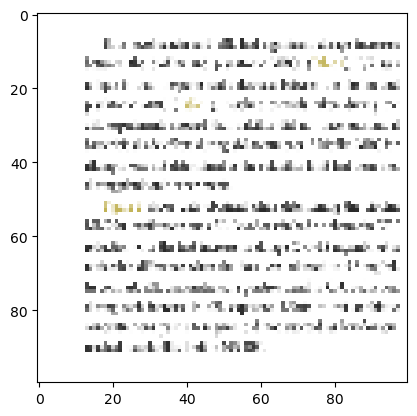

In [51]:
img3 = cv2.resize(img, (100, 100))
plt.imshow(img3)

In [52]:
query3_vectors = build_context_layout(img3)
len(query3_vectors)

KeyError: 0

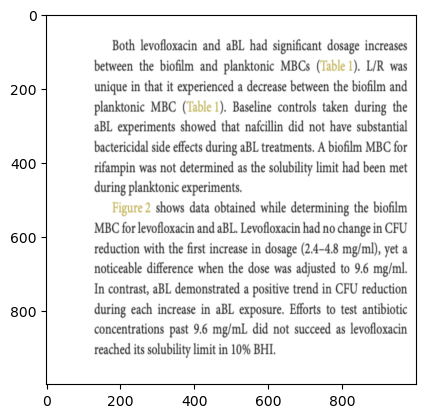

In [53]:
img4 = cv2.resize(img, (1000, 1000))
plt.imshow(img4)

In [54]:
query4_vectors = build_context_layout(img4)
len(query4_vectors)

total no of words identified: 69
total no of contexts extracted: 67


67

In [55]:
count_matches(query4_vectors,doc_vectors)

(67, 100.0)

In [83]:
count2_matches(query4_vectors,doc_vectors)

(0, 0.0)

In [56]:
count_matches(query4_vectors,query_vectors)

(67, 100.0)

In [57]:
count_matches(query2_vectors,query_vectors)

(90, 100.0)

In [60]:
count_matches(query4_vectors,query_vectors)

(67, 100.0)

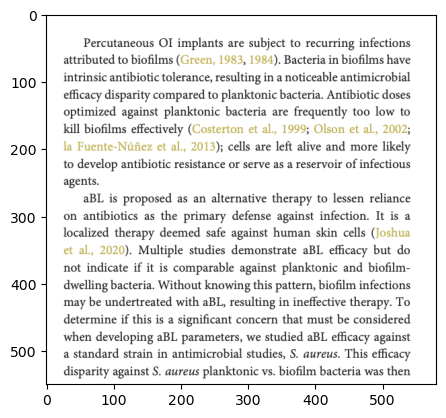

In [69]:
img21 = img_full[1100:1650, 620:1200]
plt.imshow(img21)

In [70]:
query21_vectors = build_context_layout(img21)
len(query21_vectors)

total no of words identified: 103
total no of contexts extracted: 103


103

In [76]:
count_matches(query21_vectors,doc_vectors)

(103, 100.0)

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1])